In [92]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

### Import data
# Always good to set a seed for reproducibility
SEED = 222
np.random.seed(SEED)

df = pd.read_csv('data/input.csv')
def get_train_test(test_size=0.95):
    """Split Data into train and test sets."""
    y = 1 * (df.cand_pty_affiliation == "REP")
    X = df.drop(["cand_pty_affiliation"], axis=1)
    X = pd.get_dummies(X, sparse=True)
    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    print(X.shape)
    return train_test_split(X, y, test_size=test_size, random_state=SEED)

xtrain, xtest, ytrain, ytest = get_train_test()
# xtrain = pd.DataFrame(xtrain)
# xtest = pd.DataFrame(xtest)
# ytrain = pd.DataFrame(ytrain)
# ytest = pd.DataFrame(ytest)
print(df.head())

(100000, 158)
  cand_pty_affiliation cand_office_st cand_office cand_status rpt_tp  \
0                  REP             US           P           C     Q3   
1                  DEM             US           P           C     M5   
2                  DEM             US           P           C     M3   
3                  DEM             US           P           C     Q2   
4                  REP             US           P           C    12G   

  transaction_tp entity_tp state classification   cycle  transaction_amt  
0             15       IND    NY       Engineer  2016.0            500.0  
1            15E       IND    OR      Math-Stat  2016.0             50.0  
2             15       IND    TX      Scientist  2008.0            250.0  
3            15E       IND    IN      Math-Stat  2016.0            250.0  
4             15       IND    MA       Engineer  2016.0            184.0  


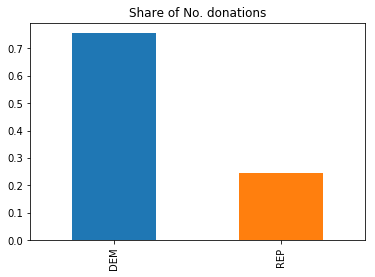

In [21]:
df.cand_pty_affiliation.value_counts(normalize=True).plot(kind='bar', title='Share of No. donations')
plt.show()

In [22]:
import pydotplus  
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

def print_graph(clf, feature_names):
    """Print decision tree."""
    graph = export_graphviz(
        clf,
        label="root",
        proportion=True,
        impurity=False, 
        out_file=None, 
        feature_names=feature_names,
        class_names={0: "D", 1: "R"},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)  
    return Image(graph.create_png())

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Decision tree ROC-AUC score: 0.751


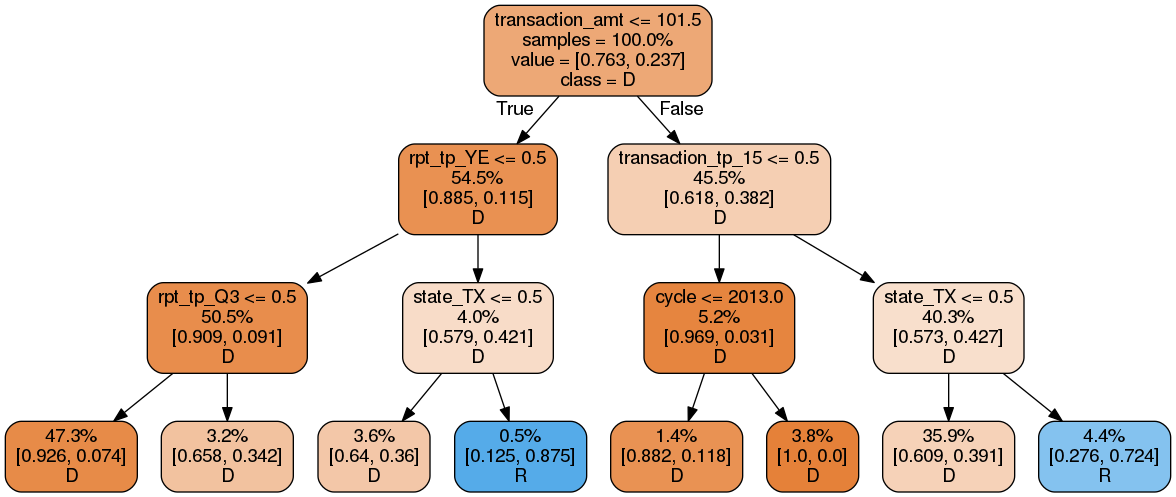

In [46]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t2, xtrain.columns)

In [49]:
print(xtrain.head())

        cycle  transaction_amt  cand_office_st_AK  cand_office_st_AL  \
34018  2008.0            250.0                  0                  0   
52563  2012.0            200.0                  0                  0   
26117  2008.0            250.0                  0                  0   
66112  2012.0            250.0                  0                  0   
33433  2010.0           1000.0                  0                  1   

       cand_office_st_AR  cand_office_st_AZ  cand_office_st_CA  \
34018                  0                  0                  0   
52563                  0                  0                  0   
26117                  0                  0                  1   
66112                  0                  0                  0   
33433                  0                  0                  0   

       cand_office_st_CO  cand_office_st_CT  cand_office_st_DC  \
34018                  0                  0                  0   
52563                  0              

Decision tree ROC-AUC score: 0.740


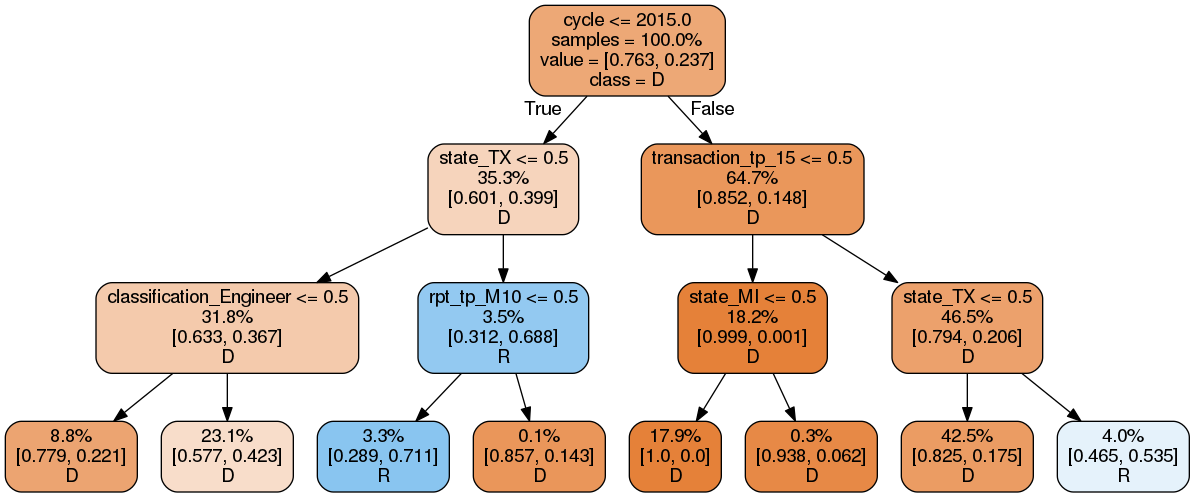

In [47]:
drop = ["transaction_amt"]
xtrain_slim = xtrain.drop(drop, axis=1)
xtest_slim = xtest.drop(drop, axis=1)

t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t3, xtrain_slim.columns)

In [53]:
p_test = t3.predict_proba(xtest_slim)
print(p_test[:5])

[[ 0.57675629  0.42324371]
 [ 1.          0.        ]
 [ 0.77904328  0.22095672]
 [ 1.          0.        ]
 [ 1.          0.        ]]


In [55]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1, p2], axis=0)
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.783


In [57]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
    random_state=SEED
)

rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Average of decision tree ROC-AUC score: 0.844


In [59]:
# A host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline


def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [60]:
models = get_models()
P = train_predict(models)
score_models(P, ytest)

Fitting models.
svm... 

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


done
gbm... done
naive bayes... done
random forest... 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


done
logistic... done
knn... 

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


done
mlp-nn... 

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


done
Done.

Scoring models.
svm                       : 0.850
gbm                       : 0.878
naive bayes               : 0.803
random forest             : 0.844
logistic                  : 0.857
knn                       : 0.779
mlp-nn                    : 0.851
Done.



[MLENS] backend: threading
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


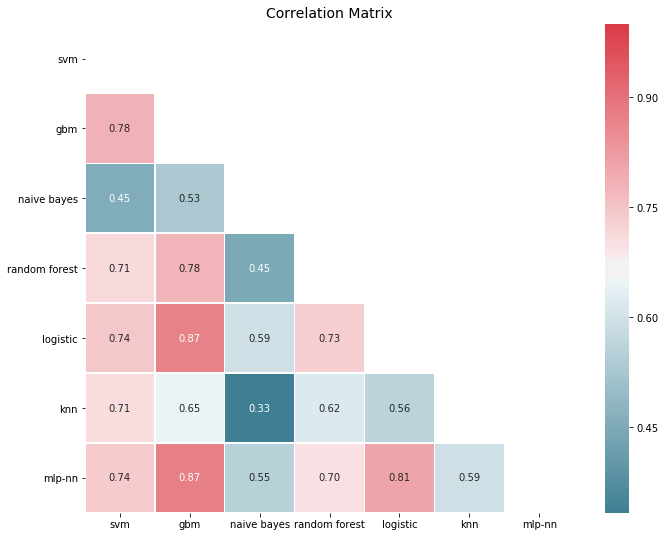

In [61]:
from mlens.visualization import corrmat

corrmat(P.corr(), inflate=False)
plt.show()

In [62]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.884


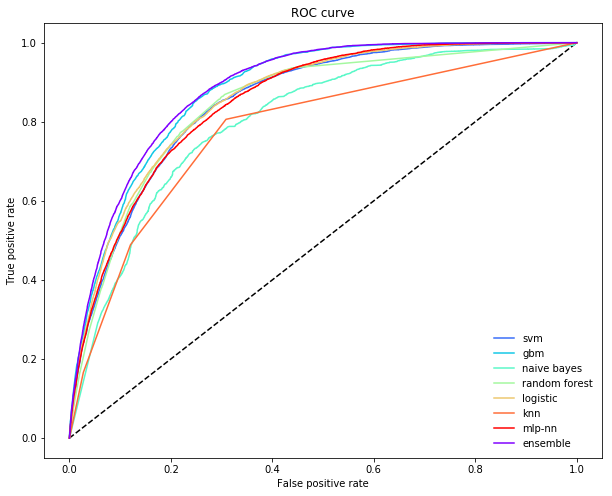

In [63]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()


plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")

In [64]:
P.head()

,svm,gbm,naive bayes,random forest,logistic,knn,mlp-nn
0,0.351309,0.265998,5.020798e-10,0.3,0.149805,0.333333,0.156115
1,0.007118,0.017165,1.085367e-68,0.0,0.002534,0.000000,0.010601
2,0.565495,0.328002,6.701134e-14,0.2,0.284237,0.333333,0.226278
3,0.044327,0.024914,2.862588e-62,0.0,0.024564,0.000000,0.049854
4,0.004237,0.017396,1.020511e-61,0.0,0.004619,0.000000,0.027849


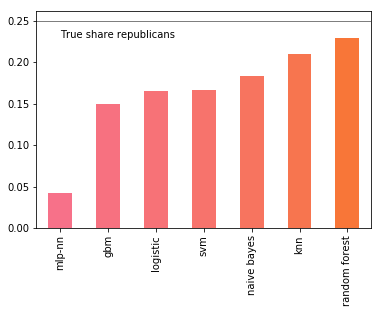

In [65]:
p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))
p.index = ["DEM", "REP"]
p.loc["REP", :].sort_values().plot(kind="bar")
plt.axhline(0.25, color="k", linewidth=0.5)
plt.text(0., 0.23, "True share republicans")
plt.show()

In [66]:
include = [c for c in P.columns if c not in ["mlp-nn"]]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.loc[:, include].mean(axis=1)))

Truncated ensemble ROC-AUC score: 0.883


### Stacking 模型

In [68]:
base_learners = get_models()
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005, 
    random_state=SEED
)
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(
    xtrain, ytrain, test_size=0.5, random_state=SEED)
def train_base_learners(base_learners, inp, out, verbose=True):
    """Train all base learners in the library."""
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

In [69]:
train_base_learners(base_learners, xtrain_base, ytrain_base)

Fitting models.
svm... 

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


done
gbm... done
naive bayes... done
random forest... done
logistic... done
knn... done
mlp-nn... 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


done


In [70]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """Generate a prediction matrix."""
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        # With two classes, need only predictions for one class
        P[:, i] = p[:, 1]
        if verbose: print("done")

    return P
P_base = predict_base_learners(base_learners, xpred_base)

Generating base learner predictions.
svm... done
gbm... done
naive bayes... done
random forest... done
logistic... done
knn... done
mlp-nn... done


In [72]:
print(P_base.shape)
print(P_base[0])

(2500, 7)
[  6.11780182e-02   1.25337787e-02   4.87126290e-52   0.00000000e+00
   2.93392209e-03   0.00000000e+00   1.06512524e-02]


In [73]:
meta_learner.fit(P_base, ypred_base)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='exponential', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=222, subsample=0.5, verbose=0,
              warm_start=False)

In [74]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]
P_pred, p = ensemble_predict(base_learners, meta_learner, xtest)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Generating base learner predictions.
svm... done
gbm... done
naive bayes... done
random forest... done
logistic... done
knn... done
mlp-nn... done

Ensemble ROC-AUC score: 0.881


### 划分为训练集和测试集虽然能满足咱们的要求，但是好像损失了一部分数据啊？那怎么办？用交叉验证来搞定！

In [94]:
from sklearn.base import clone

def stacking(base_learners, meta_learner, X, y, generator):
    """Simple training routine for stacking."""

    # Train final base learners for test time
    print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X, y, verbose=False)
    print("done")

    # Generate predictions for training meta learners
    # Outer loop:
    print("Generating cross-validated predictions...")
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):

        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]

        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model)
                              for name, model in base_learners.items()}
        train_base_learners(
            fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)

        fold_P_base = predict_base_learners(
            fold_base_learners, fold_xtest, verbose=False)

        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        
        print("Fold %i done" % (i + 1))
    
#     print('cv_y: ', cv_y[0] ,' lens ',len(cv_y))
#     print('cv_preds: ', cv_preds[0],' lens ', len(cv_preds))
    print("CV-predictions done")
    
    # Be careful to get rows in the right order
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)
    print('cv_y: ', cv_y.shape)
    print('cv_preds: ', cv_preds.shape)

    # Train meta learner
    print("Fitting meta learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    print("done")

    return base_learners, meta_learner

In [95]:
from sklearn.model_selection import KFold

# Train with stacking
cv_base_learners, cv_meta_learner = stacking(
    get_models(), clone(meta_learner), xtrain.values, ytrain.values, KFold(2))

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, xtest, verbose=False)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Fitting final base learners...done
Generating cross-validated predictions...
Fold 1 done
Fold 2 done
CV-predictions done
cv_y:  (5000,)
cv_preds:  (5000, 7)
Fitting meta learner...done

Ensemble ROC-AUC score: 0.889


#### 现在我们来想一想，这样的方法有啥问题呢？是不是速度会比较慢呀！推荐大家用下面的并行方法，速度大大提升！

In [96]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=SEED,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(xtrain, ytrain)

# Predict the test set
p_sl = sl.predict_proba(xtest)

print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(ytest, p_sl[:, 1]))


Fitting 2 layers
Processing layer-1             done | 00:01:35
Processing layer-2             done | 00:00:03
Fit complete                        | 00:01:41

Predicting 2 layers
Processing layer-1             done | 00:00:53
Processing layer-2             done | 00:00:01
Predict complete                    | 00:00:57

Super Learner ROC-AUC score: 0.890


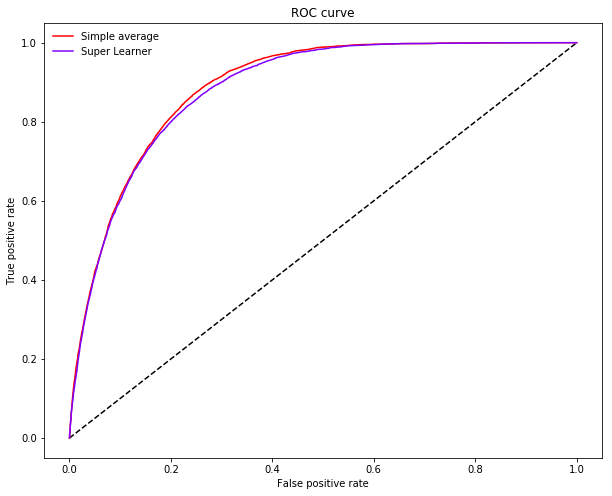

In [97]:
plot_roc_curve(ytest, p.reshape(-1, 1), P.mean(axis=1), ["Simple average"], "Super Learner")